# Using Enformer Celltyping

This workbook steps through the different use cases for the trained, Enformer Celltyping model.

To begin, download all necessary reference files for Enformer Celltyping by running the following
in the command line from within the downloaded repo - `EnformerCelltyping/`:

```
conda env create -f ./environment/enformer_celltyping.yml &&\
make env &&\
conda activate EnformerCelltyping &&\
pip install -e . &&\
python bin/download_Enformer_Celltyping_dependencies.py
```

This will download:
  1. The saved weights for the trained Enformer Celltyping model (`./enformer_celltyping`)
  2. The hg19/GRCh37 reference genome split by nucleotide, saved as a bigWig file (`./data/dna/`)
  3. The average chromatin accessibility signal for the 103 [EpiMap](http://compbio.mit.edu/epimap/) training cell types (`./data/model_ref`)
  4. The [ENCODE Blacklist](https://www.nature.com/articles/s41598-019-45839-z) regions (`./data/model_ref/`)
  5. The trained [enformer model](https://www.nature.com/articles/s41592-021-01252-x) from Tensorflow Hub (`./data/enformer_model/`)
  6. BigWig Microglia chromatin accessibility signal at 128 base-pair resolution (`./data/demo/`)
  
Some notes on the usage of these in the model:
  * **Enformer Celltyping model** - The model after training regeme outlined in [full_training_recreation.ipynb](https://github.com/neurogenomics/EnformerCelltyping/blob/master/full_training_recreation.ipynb) and in our manuscript.
  * **hg19 genome reference** - Needed to make any predictions by the model, pass the DNA from that genomic region.
  * **average chromatin accessibility** - Used as input to the model along with the cell type specific chromatin accessibility.
  * **ENCODE Blacklist** - These regions can be excluded from predictions.
  * **Trained enformer model** - This model is processed to remove final layers to enable transfer learning in Enformer Celltyping.
  * **Microglia chromatin accessibility signal** - data taken from [Nott et al. 2019](https://www.science.org/doi/10.1126/science.aay0793?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub=pubmed) which has been processed as discribed in section 1.1 so it is ready for input to Enformer Celltyping. We will use this to demo Enformer Celltyping's functionality


## 1. Predicting with Enformer Celltyping

The first thing we can do with Enformer Celltyping is predict the cell type-specific histone marks for a particular
region of the genome. To make a prediction of the histone mark signal for your cell type/tissue of interest, you need the corresponding chromatin accessibility (ATAC-Seq data).


### 1.1 Processing your cell type-specific chromatin accessibility data

The data needs to be the -log10 p-value signal for every base-pair, in bigWig format. This is an output after peak calling but **note** that this is not the default output type. The easiest way to get this data is to run the [ENCODE ATAC Pipeline](https://github.com/ENCODE-DCC/atac-seq-pipeline) with the raw FASTQ files from your study. Make sure to use the hg19 reference genome as this is the reference genome for which Enformer Celltyping predicts. Once run, the bigWig file with the pooled -log10 p-value should be in the following folder: 

```
./atac/<run-id>/call-macs2_signal_track_pooled/execution/rep.pooled.pval.signal.bigwig
```

Now, this file will be averaged to 25 base-pairs whereas the model takes 128 base-pair averaged chromatin accessibility. To update the file to 128 base-pair averaging, activate the `r_bioc` (`conda activate r_bioc` - this was created with the `mke env` call earlier) and run:

```
Rscript ./bin/avg_bigwig_tracks.R path/to/bigwig/file 128
```

This will create the 128 base-pair averaged bigWig file in the same location as the original with `_128` appended to the name. Now you are ready to pass your data to Enformer Celltyping and get some predictions.

### 1.2 Predicting histone mark signals

To show how to predict there is a chromatin accessibility (ATAC-Seq) bigWig file, averaged at 128 base-pairs for Microglia sourced from [Brain cell type–specific enhancer–promoter interactome maps and disease-risk association](https://www.science.org/doi/10.1126/science.aay0793?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%3dpubmed). This will be used for demostration purposes.


In [1]:
#first let's sort our data loader

#use the following:
#PROJECT_PATH - path to the EnformerCelltyping repo to get relative paths
from EnformerCelltyping.constants import PROJECT_PATH

#path to the cell type-specific chromatin accessibility bigWig
chrom_access_pth = str(PROJECT_PATH /'data/demo/Nott19_Microglia_128.bigWig')
#give the name of the cell
cell = 'Nott19_Microglia'

#import the data generator which will take care of any preprocessing
from EnformerCelltyping.utils import generate_sample

#data generator class for samples
data_generator = generate_sample(
    cells = {cell:chrom_access_pth}, #should be a dict
    )

2023-02-08 17:36:48.044308: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#load Enformer celltyping model
import tensorflow as tf
from EnformerCelltyping.enf_celltyping import Enformer_Celltyping

#load histone marks from constants so the ordering of predictions is known
from EnformerCelltyping.constants import PRED_HIST_MARKS

hist_marks = PRED_HIST_MARKS

model = Enformer_Celltyping(enf_path=str(PROJECT_PATH / "data/enformer_model"),#path to enformer model
                            use_prebuilt_model=True,
                            enf_celltyping_pth = str(PROJECT_PATH /'EnformerCelltyping'/'enformer_celltyping_weights')
                           )
#compile loaded model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss=tf.keras.losses.mean_squared_error,
              #mse for each hist mark
              metrics=['mse'])

2023-02-08 17:36:51.447894: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-08 17:36:51.463298: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 17:36:51.463320: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (workstation-neurogenomics): /proc/driver/nvidia/version does not exist
2023-02-08 17:36:51.463772: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 17:37:21.605849: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the f

Now let's predict

Let's predict at the TSS of [Iba1/AIF-1](https://grch37.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000204472;r=6:31582961-31584798) Gene

This is a microglia marker gene

Found at Chromosome 6: 31,582,961-31,584,798 hg19

In [3]:
#load data for a specific genomic position
tss = 31_582_961
dna_window = 196_608
chro='chr6'
#we want the TSS centered in the prediction
#pos is the start of the DNA window
strt = tss-(dna_window//2)
end = tss+(dna_window//2)
X = data_generator.load(pos=strt,
                           chro=chro,cell=cell)
print({key:item.shape for key, item in X.items()})

{'dna': TensorShape([1, 196608, 4]), 'chrom_access_lcl': TensorShape([1, 1562]), 'chrom_access_gbl': TensorShape([1, 14592])}


So you can see the data loader has returneda dictionary of tensors containing the DNA sequence for the region (one-hot encoded) (`dna`) along with the local and global chromatin accessibility data for the cell type. The local chromatin accessibility (`chrom_access_lcl`) is the chromatin accessiblity signal for the same region as the DNA whereas the global chromatin accessibility is the chromatin accessibility from the transcriptional start site (3k base-pairs) for all known marker genes taken from [PangloaDB](https://panglaodb.se/) (`chrom_access_gbl`). Both these signals correspond to the arc-sin transformed chromatin accessibility data for the cell type of interest. Enformer Celltyping uses arc-sin transformed signal as a method to deal with differing sequencing depths and other batch effects across studies. The global chromatin accessibility signal is averaged at 250 base-pairs whereas the local chromatin accessibility signal is at 128 base-pairs.

So the model uses the DNA sequence to highlight DNA interactions based on sequence to predict an average histone mark signal. The chromatin accessibility data is jointly used to derive the cell type-specific histone mark signal based on this average. In this manner, the cell type specificity of the model is derived from chromatin accessibility. We include the gobal and local signal so the model can have an understanding of the cell type (global) and the region in which it is trying to predict (local).

Now we can pass this data to our model to predict.

In [4]:
#Now let's predict
pred = model.predict(X)
pred.shape

2023-02-08 17:38:14.800543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-08 17:38:14.839744: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1996250000 Hz


(1, 896, 6)

So the shape of the output is (1,896,6) matrix where 1 is the number of samples we predicted, 896 is the length of the genomic region we predicted for (where each 1 corresponds to 128 base-pairs) and 6 is the six separate histone marks we predicted for. Let's plot the prediction to view the signals.

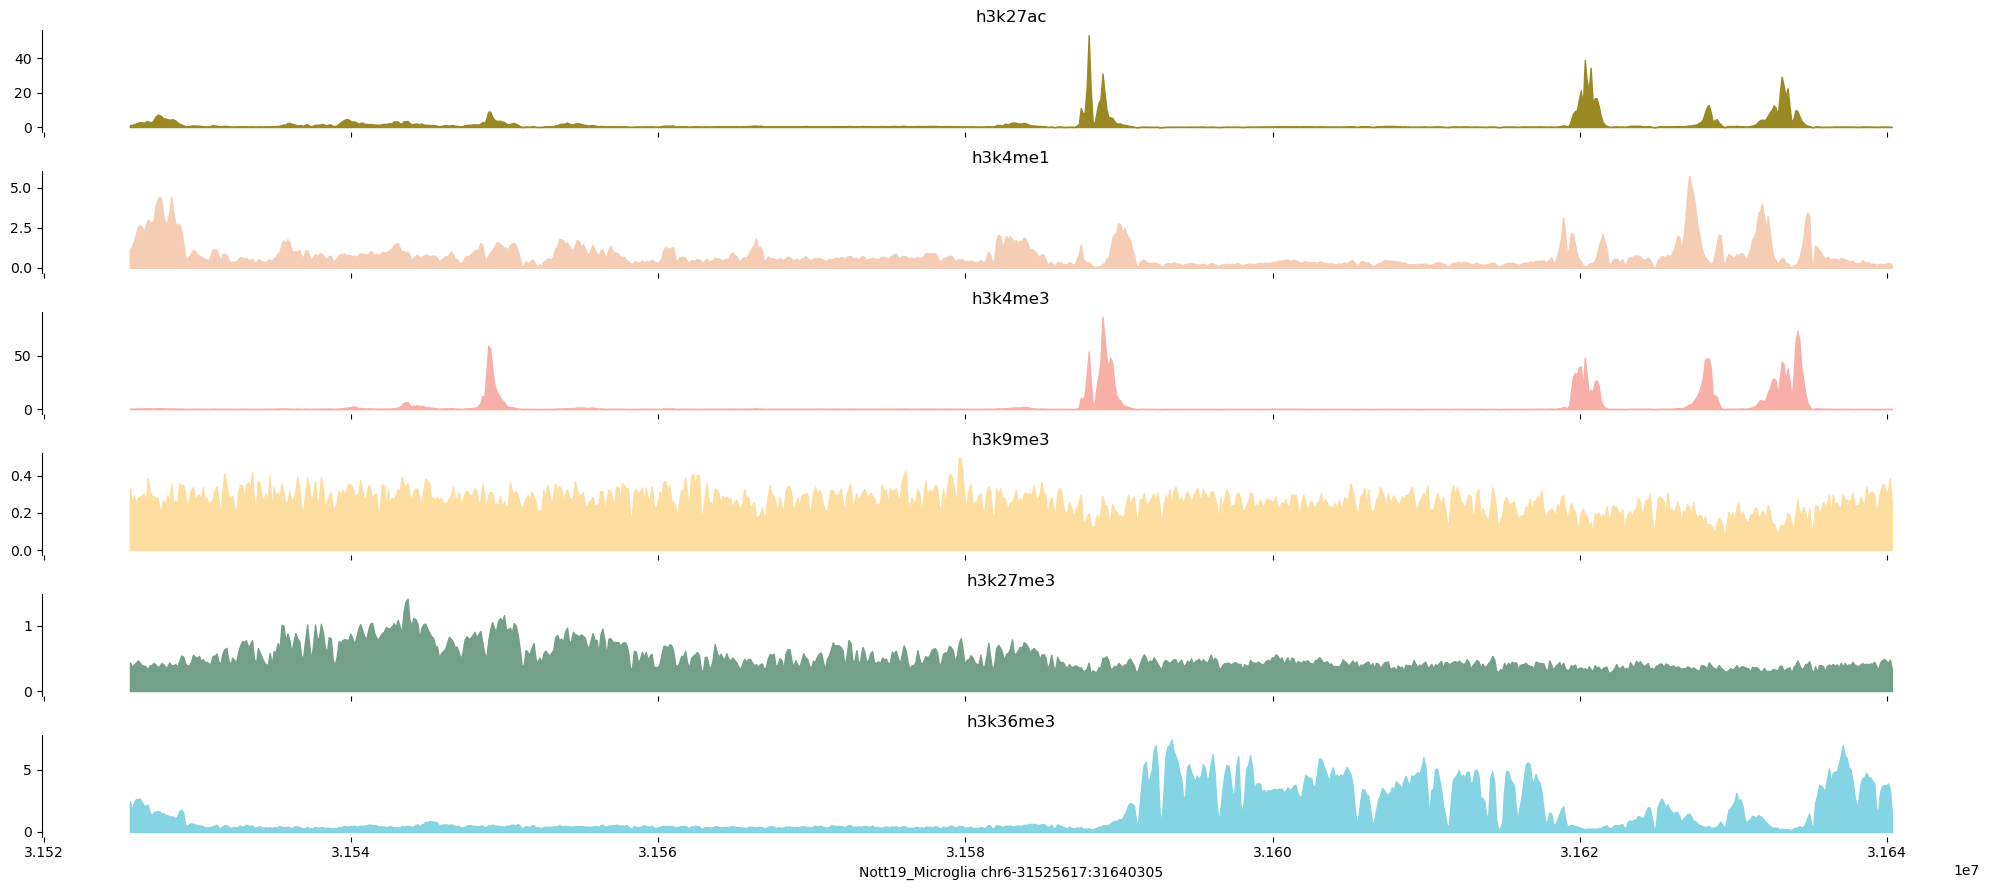

In [5]:
#get order of histone marks in predictions
from EnformerCelltyping.constants import PRED_HIST_MARKS
#make plotting easier
from EnformerCelltyping.utils import plot_signal
    
#make dict with histone mark prediction and name
#get the prediction window, Enformer Celltyping pridicts in a funnel shape
#where it won't predict for every base-pair of the input length
#get bp size of DNA input
from EnformerCelltyping.constants import WINDOW_SIZE_DNA
#use buffer to deal with funnel
buffer = (WINDOW_SIZE_DNA - pred.shape[1]*128)//2
#create intterval dict for plotting
interval = {'start':strt+buffer,'end':end-buffer,
            'chro':chro,'cell':cell}
#now plot
plot_signal({i:pred[0,:,ind] for ind,i in enumerate(PRED_HIST_MARKS)},
            interval)

#### Predicting entire genome (CHR 1-22)

You may want to predict the entire genome and save the result as a bigWig file (a separate one for each histone mark). This can be done on the command line. See below for the command to use with the EnformerCelltyping conda env to make a biwig for each histone mark for the microglia from [Nott et al., 2019](https://www.science.org/doi/10.1126/science.aay0793?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%3dpubmed):

```
python ./bin/predict_genome.py -c Nott19_Microglia -p data/demo/Nott19_Microglia_128.bigWig -o ./model_results/predictions/
```

**Note** this will run a lot quicker with a GPU but will likely take in the order of hours to run. Also make sure to process your ATAC-seq data as described in section 1.1 before running the above on it.

## 2. Testing Enformer Celltyping's receptive field

Although Enformer Celltyping takes in ~200k of DNA to make it's predictions, it is not guaranteed that a model will pay attention to the full width of the input length (this is especially true for convolutional models as the input size increases). 

We can test Enformer Celltyping's receptive field by passing it random DNA sequences and then permuting the base-pair at different positions to check if the change has any effect on the model's outputted prediction. By using many random sequences of DNA and many random changes of base-pairs, at many locations of the input window, we can get a good idea of how much a position will contribute to the prediction. We can then aggregate this contribution and plot it against the input position that's permutation caused the contribution. That's exactly what the function below does so let's run it on Enformer Celltyping.

In [17]:
from EnformerCelltyping.utils import measure_receptive_field

# Set random seeds so same data used for both
np.random.seed(101)

#increase the number of iterations and number of positions tested to increase accuracy
N_iter= 4
N_pos= 20

ec_data,ec_mut_eff_size = measure_receptive_field(model, seq_length= 196_608,
                                                  N_iter= N_iter,N_pos= N_pos)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [56:27<00:00, 169.37s/it]


/tmp/ipykernel_2213642/2922207094.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


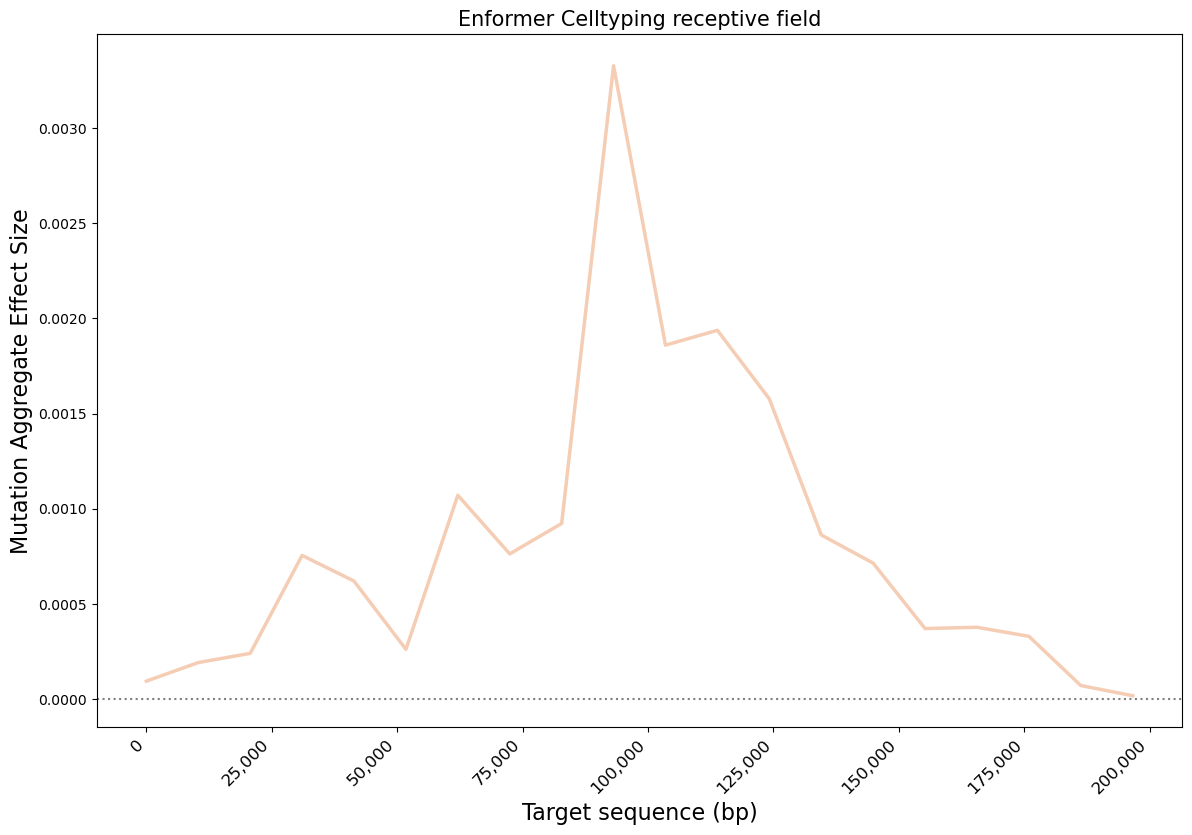

In [39]:
#now let's plot

import matplotlib.pyplot as plt

col = "#F5CDB4"

fig, ax = plt.subplots(figsize=(14, 9))

plt.rc('axes', titlesize=15, labelsize=14)
label_format = '{:,.0f}'

ax.plot(ec_data.keys(),ec_mut_eff_size,
        linewidth=2.5,
        color=col)
ax.set_title(f"Enformer Celltyping receptive field")
ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels(
    [label_format.format(x) for x in ticks_loc],
    rotation=45,
    fontsize=12,
    ha="right"
)
ax.set_xlabel('Target sequence (bp)', fontsize=16)
ax.set_ylabel('Mutation Aggregate Effect Size', fontsize=16)
ax.axhline(y=0, color='grey', linestyle='dotted')

We can see even at this low numebr of iterations, that there is a noticable effect of permuting a base-pair at the edge of the ~200k input (look at position 0). You can replciate the receptive field in our manuscript by increasing the `N_iter` and `N_pos` values but note this will take some time to run.